<a id='toc'></a>
# Predictive Modelling
Here we train and tune three predictive models: Logistic Regression, Random Forest and AdaBoost.

1. [Setting up the Environment](#envir)
1. [Loading Data Post Correlation Analysis](#load)
1. [Predictive Modelling Function](#function)
1. [Initial Training of Models](#train)
    1. [Logistic Regression](#LR)
        1. [No Sampling](#lr_no)
        1. [Over Sampling](#lr_ovr)
        1. [Under Sampling](#lr_und)
    1. [Random Forest](#RF)
        1. [No Sampling](#rf_no)
        1. [Over Sampling](#rf_ovr)
        1. [Under Sampling](#rf_und)
    1. [AdaBoost](#ADA)
        1. [No Sampling](#ada_no)
        1. [Over Sampling](#ada_ovr)
        1. [Under Sampling](#ada_und)
1. [Summary of Initial Training Results](#int_summary)
1. [Model Tuning](#tune)
    1. [Grid Search](#grid)
        1. [Logistic Regression](#grid_lr)
        1. [Random Forest](#grid_rf)
        1. [AdaBoost](#grid_ada)
1. [Summary of Tuning Results](#tune_summary)

<a id='envir'></a>
# 1. Setting up the Environment

[Return](#toc)

In [2]:
import numpy as np
import pandas as pd
from numpy import nan as NaN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
#import os
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
#%matplotlib inline

<a id='load'></a>
# 2. Loading Training Set

[Return](#toc)

In [2]:
# Read in the data post correlation analysis
path = 'C:/Users/X/Documents/A_Documents/Cap_Data/CSV'
train_set = pd.read_csv(path + '/train_test_sets/train_set_std.csv')
train_labels = pd.read_csv(path + '/train_test_sets/train_labels.csv')

In [3]:
# A quick look at the data
train_set.shape

(215257, 259)

In [4]:
train_labels.shape

(215257, 1)

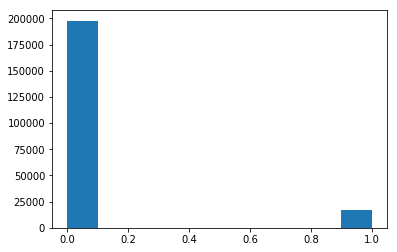

In [4]:
# A quick look at the imbalanced labels
train_labels['TARGET'].hist(grid=False);

In [3]:
train_labels['TARGET'].value_counts()

0    197880
1     17377
Name: TARGET, dtype: int64

<a id='function'></a>
# 3. Predictive Modelling Function

[Return](#toc)

In [10]:
# A function to perform cross validation 
# with three different choices of sampling method

def classify_folds(clr, train_x, train_y, sample_method, folds):
    
    # Lists to store metrics
    aucs=[]
    recall=[]
    precision=[]
    f1score=[]
    accuracy=[]

    # Create the random under & over samplers
    rus = RandomUnderSampler(random_state=777)
    smote = SMOTE(ratio='minority', random_state=777, n_jobs=-1)

    # Create the folds
    splits = KFold(n_splits=folds).split(train_x, train_y)

    fig = plt.figure(figsize=(8,6))
    i=0
    
    # Iterate through the folds
    for train_fold, test_fold in splits:
        # Depending on choice of sampling method - execute sampling
        if sample_method == 'under':
            sampled_x, sampled_y = rus.fit_sample(train_x[train_fold], train_y[train_fold])
        elif sample_method == 'over':
            sampled_x, sampled_y = smote.fit_sample(train_x[train_fold], train_y[train_fold])
        elif sample_method == 'none':
            sampled_x, sampled_y = train_x[train_fold], train_y[train_fold]            
        else:
            print('Incorrect Sample Input')
            return
    
        # Train the classifier on the sampled data
        clr.fit(sampled_x, sampled_y)
    
        # Test the classifier on the test fold (which is not sampled and remains imbalanced)
        probs = clr.predict_proba(train_x[test_fold])
        predict = clr.predict(train_x[test_fold])
        
        # Return arrays containing the fpr (x-axis), tpr (y-axis) and thresholds
        fpr, tpr, thresholds = roc_curve(train_y[test_fold], probs[:, 1])
    
        # Compute area under ROC curve
        roc_auc = auc(fpr, tpr)
    
        # Plot ROC curve
        plt.plot(fpr, tpr, lw=1, alpha=0.8, label='Fold %d (AUC = %0.2f)' % (i, roc_auc))
    
        # Generate confusion matrix, compute measures and store
        matrix = confusion_matrix(train_y[test_fold], predict)
        TP = matrix[1,1]
        TN = matrix[0,0]
        FP = matrix[0,1]
        FN = matrix[1,0]
        rec = TP/(TP+FN)
        prec = TP/(TP+FP)
        f1 = 2*prec*rec/(prec+rec)
        acc = (TP+TN) /(TP+TN+FP+FN)
    
        aucs.append(roc_auc)
        recall.append(rec)
        precision.append(prec)
        f1score.append(f1)
        accuracy.append(acc)
        print(i,end="")
        i += 1
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('ROC Curves', fontsize=15)
    plt.legend(loc='lower right'); 

    # Dataframes to return results
    matrix = pd.DataFrame(matrix)
    matrix.index.name = 'Actual'; matrix.columns.name = 'Predicted'
    results = pd.DataFrame({'ROC_AUC':aucs, 'Recall':recall, 'Precision':precision, 'F1-Score':f1score, 'Accuracy':accuracy})
    mean = results.mean(); mean.name = 'Mean'
    return results.append(mean), fig, matrix

<a id='train'></a>
# 4. Initial Training of Models
Below we experiment with three models: Logistic Regression, Random Forest and AdaBoost. All models are trained using default hyperparameters, 10 fold cross validation and three different sampling techniques: no sampling, oversampling the minority class (TARGET = 1, default) and under sampling the majority class (TARGET = 0, no default).

[Return](#toc)

<a id='LR'></a>
## A. Logistic Regression

[Return](#toc)

<a id='lr_no'></a>
### a. Logistic Regression - No Sampling

[Return](#toc)

0123456789
Confusion matrix from last fold:

Predicted      0   1
Actual              
0          19749  32
1           1722  22

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.743444  0.012709   0.415094  0.024664  0.919168
1     0.753314  0.009297   0.347826  0.018110  0.919400
2     0.746064  0.013113   0.534884  0.025598  0.918657
3     0.763035  0.019918   0.492754  0.038288  0.920654
4     0.749218  0.010820   0.500000  0.021182  0.918424
5     0.755003  0.017762   0.566038  0.034443  0.921862
6     0.748396  0.019069   0.596491  0.036957  0.917681
7     0.754640  0.014582   0.481481  0.028307  0.917073
8     0.751953  0.018724   0.533333  0.036179  0.920790
9     0.739173  0.012615   0.407407  0.024472  0.918513
Mean  0.750424  0.014861   0.487531  0.028820  0.919222


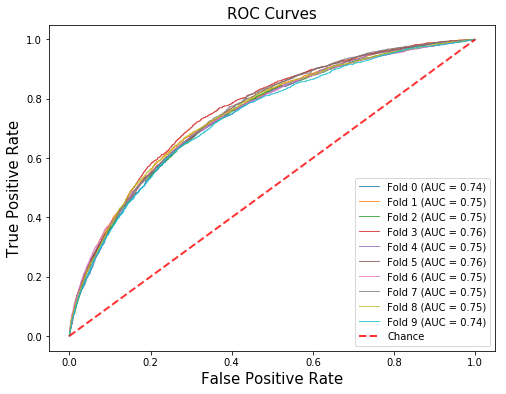

In [25]:
# Defining the classifier
clr = LogisticRegression()

# Calling the cross validation function
metrics, chart, matrix = classify_folds(clr, np.array(train_set), np.array(train_labels), 'none', 10)
print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

# Saving results to CSV files
metrics.to_csv(path+'/results/LR_None.csv')
chart.savefig(path+'/results/LR_None.png')

<a id='lr_ovr'></a>
### b. Logistic Regression - Over Sampling

[Return](#toc)

0123456789
Confusion matrix from last fold:

Predicted      0     1
Actual                
0          13867  5914
1            638  1106

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.730229  0.643559   0.159599  0.255769  0.698829
1     0.745273  0.660662   0.163104  0.261620  0.701849
2     0.735292  0.629989   0.162261  0.258057  0.704822
3     0.748661  0.670767   0.165415  0.265384  0.705519
4     0.734414  0.641230   0.161041  0.257430  0.698225
5     0.738866  0.644760   0.157780  0.253521  0.702081
6     0.738063  0.635446   0.163657  0.260280  0.700827
7     0.738178  0.633202   0.161401  0.257234  0.697096
8     0.739162  0.658280   0.162831  0.261081  0.704158
9     0.727371  0.634174   0.157550  0.252396  0.695610
Mean  0.737551  0.645207   0.161464  0.258277  0.700902


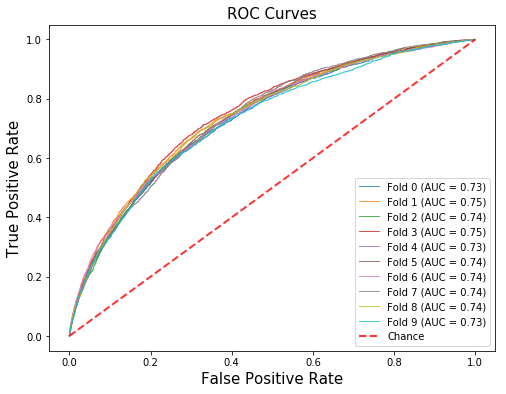

In [26]:
# Defining the classifier
clr = LogisticRegression()

# Calling the cross validation function
metrics, chart, matrix = classify_folds(clr, np.array(train_set), np.array(train_labels), 'over', 10)
print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

# Saving results to CSV files
metrics.to_csv(path+'/results/LR_Over.csv')
chart.savefig(path+'/results/LR_Over.png')

<a id='lr_und'></a>
### c. Logistic Regression - Under Sampling

[Return](#toc)

0123456789
Confusion matrix from last fold:

Predicted      0     1
Actual                
0          13570  6211
1            573  1171

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.740908  0.683420   0.159391  0.258494  0.684707
1     0.751429  0.688553   0.160049  0.259726  0.686193
2     0.743626  0.664196   0.159197  0.256834  0.686797
3     0.760820  0.707088   0.164733  0.267213  0.692465
4     0.747297  0.681093   0.160602  0.259915  0.683592
5     0.752751  0.678508   0.157916  0.256204  0.690885
6     0.745859  0.680314   0.163830  0.264069  0.685915
7     0.754397  0.693214   0.166040  0.267909  0.686179
8     0.749475  0.688707   0.160420  0.260226  0.689106
9     0.735518  0.671445   0.158629  0.256629  0.684832
Mean  0.748208  0.683654   0.161081  0.260722  0.687067


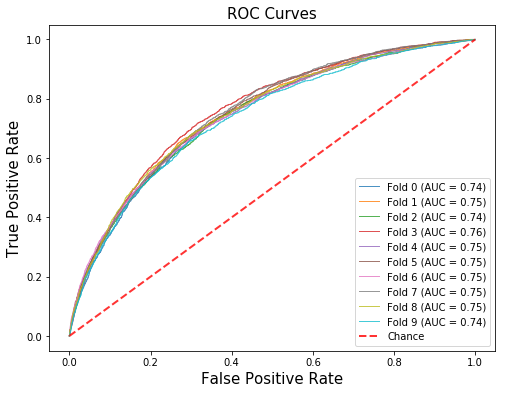

In [27]:
# Defining the classifier
clr = LogisticRegression()

# Calling the cross validation function
metrics, chart, matrix = classify_folds(clr, np.array(train_set), np.array(train_labels), 'under', 10)
print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

# Saving results to CSV files
metrics.to_csv(path+'/results/LR_Under.csv')
chart.savefig(path+'/results/LR_Under.png')

<a id='RF'></a>
## B. Random Forest

[Return](#toc)

<a id='rf_no'></a>
### a. Random Forest - No Sampling

[Return](#toc)

0123456789
Confusion matrix from last fold:

Predicted      0   1
Actual              
0          19746  35
1           1720  24

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.638033  0.010976   0.441860  0.021421  0.919353
1     0.634540  0.006392   0.255814  0.012472  0.919075
2     0.638592  0.011403   0.392157  0.022161  0.918006
3     0.642255  0.013474   0.410714  0.026092  0.920236
4     0.640781  0.014806   0.426230  0.028619  0.918006
5     0.641315  0.011841   0.333333  0.022870  0.920608
6     0.630693  0.009534   0.425000  0.018651  0.916891
7     0.636584  0.003926   0.159091  0.007663  0.915772
8     0.634095  0.009362   0.400000  0.018296  0.920232
9     0.636892  0.013761   0.406780  0.026622  0.918467
Mean  0.637378  0.010548   0.365098  0.020487  0.918665


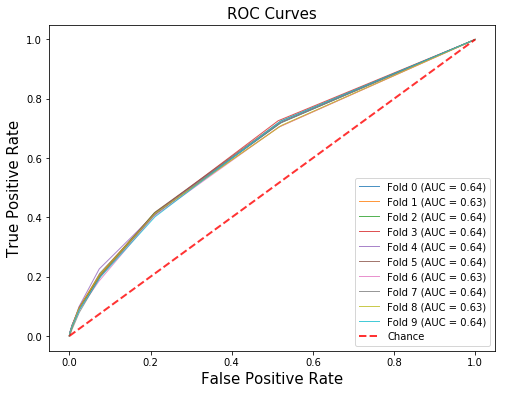

In [19]:
# Defining the classifier
clr = RandomForestClassifier(n_jobs=-1, random_state=777)

# Calling the cross validation function
metrics, chart, matrix = classify_folds(clr, np.array(train_set), np.array(train_labels), 'none', 10)
print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

# Saving results to CSV files
metrics.to_csv(path+'/results/RandFor_None.csv')
chart.savefig(path+'/results/RandFor_None.png')

<a id='rf_ovr'></a>
### b. Random Forest - Over Sampling

[Return](#toc)

0123456789
Confusion matrix from last fold:

Predicted      0    1
Actual               
0          19639  142
1           1700   44

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.631419  0.031774   0.239130  0.056094  0.914011
1     0.635016  0.033701   0.247863  0.059335  0.914568
2     0.629805  0.023375   0.194313  0.041730  0.912524
3     0.646083  0.033978   0.254386  0.059948  0.915498
4     0.634452  0.031321   0.230126  0.055138  0.912431
5     0.641619  0.036708   0.233962  0.063460  0.914987
6     0.623942  0.030286   0.247706  0.053973  0.912060
7     0.637230  0.029725   0.240909  0.052921  0.911870
8     0.635884  0.034523   0.285024  0.061587  0.916469
9     0.630292  0.025229   0.236559  0.045596  0.914425
Mean  0.634574  0.031062   0.240998  0.054978  0.913884


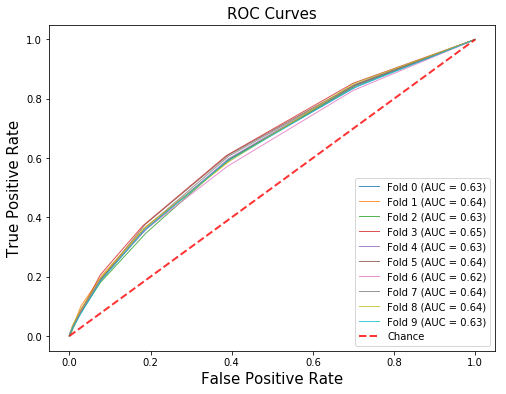

In [20]:
# Defining the classifier
clr = RandomForestClassifier(n_jobs=-1, random_state=777)

# Calling the cross validation function
metrics, chart, matrix = classify_folds(clr, np.array(train_set), np.array(train_labels), 'over', 10)
print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

# Saving results to CSV files
metrics.to_csv(path+'/results/RandFor_Over.csv')
chart.savefig(path+'/results/RandFor_Over.png')

<a id='rf_und'></a>
### c. Random Forest - Under Sampling

[Return](#toc)

0123456789
Confusion matrix from last fold:

Predicted      0     1
Actual                
0          14189  5592
1            833   911

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.670540  0.525130   0.136630  0.216842  0.694974
1     0.678366  0.555491   0.142474  0.226782  0.697157
2     0.675685  0.540479   0.147205  0.231389  0.707424
3     0.692617  0.567077   0.146378  0.232692  0.703428
4     0.672107  0.537585   0.142019  0.224682  0.697343
5     0.680246  0.548845   0.139503  0.222462  0.698969
6     0.678097  0.545709   0.145724  0.230024  0.697389
7     0.686688  0.556366   0.148860  0.234876  0.699744
8     0.676974  0.540667   0.139388  0.221636  0.698490
9     0.668983  0.522362   0.140089  0.220929  0.701510
Mean  0.678030  0.543971   0.142827  0.226231  0.699643


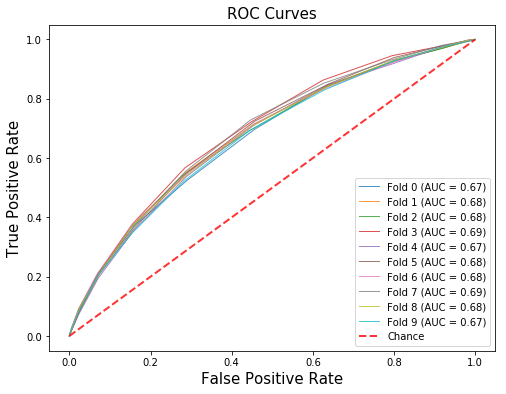

In [21]:
# Defining the classifier
clr = RandomForestClassifier(n_jobs=-1, random_state=777)

# Calling the cross validation function
metrics, chart, matrix = classify_folds(clr, np.array(train_set), np.array(train_labels), 'under', 10)
print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

# Saving results to CSV files
metrics.to_csv(path+'/results/RandFor_Under.csv')
chart.savefig(path+'/results/RandFor_Under.png')

<a id='ADA'></a>
## C. AdaBoost

[Return](#toc)

<a id='ada_no'></a>
### a. AdaBoost - No Sampling

[Return](#toc)

0123456789
Confusion matrix from last fold:

Predicted      0   1
Actual              
0          19730  51
1           1706  38

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.737986  0.020220   0.426829  0.038610  0.919028
1     0.748209  0.024985   0.483146  0.047514  0.919911
2     0.746848  0.019384   0.515152  0.037363  0.918610
3     0.760238  0.024605   0.518519  0.046980  0.920840
4     0.752166  0.021640   0.413043  0.041126  0.917681
5     0.749440  0.025459   0.551282  0.048670  0.921908
6     0.743617  0.022434   0.533333  0.043057  0.917402
7     0.748317  0.016826   0.410959  0.032328  0.916562
8     0.752689  0.024576   0.512195  0.046901  0.920697
9     0.733311  0.021789   0.426966  0.041462  0.918374
Mean  0.747282  0.022192   0.479142  0.042401  0.919101


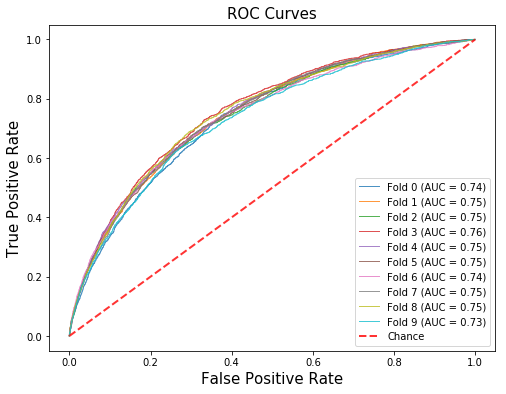

In [22]:
# Defining the classifier
clr = AdaBoostClassifier(random_state=777)

# Calling the cross validation function
metrics, chart, matrix = classify_folds(clr, np.array(train_set), np.array(train_labels), 'none', 10)
print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

# Saving results to CSV files
metrics.to_csv(path+'/results/AdaBoost_None.csv')
chart.savefig(path+'/results/AdaBoost_None.png')

<a id='ada_ovr'></a>
### b. AdaBoost - Over Sampling

[Return](#toc)

0123456789
Confusion matrix from last fold:

Predicted      0     1
Actual                
0          18723  1058
1           1490   254

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.671083  0.159445   0.178872  0.168601  0.873548
1     0.684906  0.150494   0.196361  0.170395  0.882839
2     0.670077  0.127138   0.182937  0.150017  0.882607
3     0.686193  0.151728   0.185663  0.166989  0.879959
4     0.673174  0.124146   0.178689  0.146505  0.882003
5     0.679646  0.173475   0.190879  0.181762  0.877451
6     0.667634  0.164330   0.211705  0.185033  0.880098
7     0.677633  0.163208   0.203070  0.180970  0.877631
8     0.676341  0.172030   0.183750  0.177697  0.873589
9     0.675684  0.145642   0.193598  0.166230  0.881626
Mean  0.676237  0.153164   0.190552  0.169420  0.879135


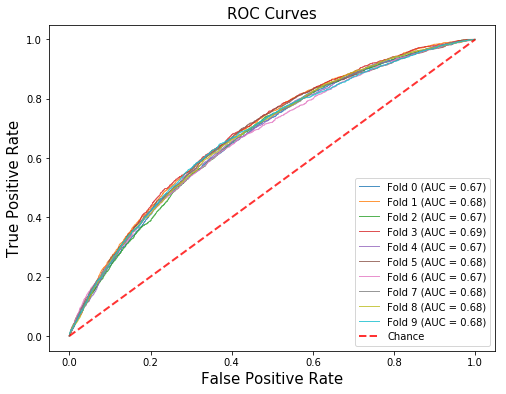

In [23]:
# Defining the classifier
clr = AdaBoostClassifier(random_state=777)

# Calling the cross validation function
metrics, chart, matrix = classify_folds(clr, np.array(train_set), np.array(train_labels), 'over', 10)
print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

# Saving results to CSV files
metrics.to_csv(path+'/results/AdaBoost_Over.csv')
chart.savefig(path+'/results/AdaBoost_Over.png')

<a id='ada_und'></a>
### c. AdaBoost - Under Sampling

[Return](#toc)

0123456789
Confusion matrix from last fold:

Predicted      0     1
Actual                
0          13621  6160
1            590  1154

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.736917  0.669555   0.156643  0.253888  0.683545
1     0.747395  0.673446   0.159620  0.258072  0.690421
2     0.742260  0.664196   0.159764  0.257572  0.688005
3     0.757766  0.684241   0.162629  0.262797  0.695577
4     0.744847  0.670273   0.159377  0.257521  0.684707
5     0.748674  0.663706   0.155070  0.251402  0.689863
6     0.744465  0.680314   0.165462  0.266184  0.689306
7     0.742253  0.667975   0.161207  0.259732  0.684599
8     0.749892  0.687537   0.162024  0.262248  0.692869
9     0.735089  0.661697   0.157780  0.254802  0.686411
Mean  0.744956  0.672294   0.159958  0.258422  0.688530


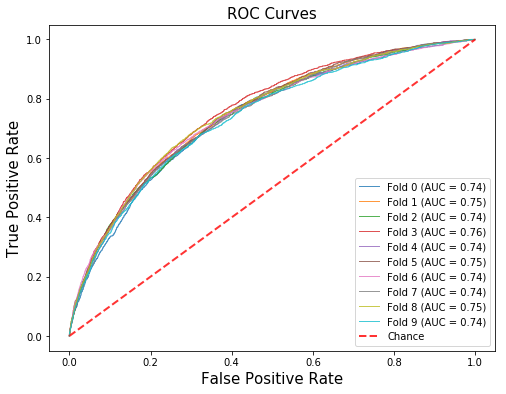

In [24]:
# Defining the classifier
clr = AdaBoostClassifier(random_state=777)

# Calling the cross validation function
metrics, chart, matrix = classify_folds(clr, np.array(train_set), np.array(train_labels), 'under', 10)
print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

# Saving results to CSV files
metrics.to_csv(path+'/results/AdaBoost_Under.csv')
chart.savefig(path+'/results/AdaBoost_Under.png')

<a id='int_summary'></a>
# 5. Summary of Initial Training Results

[Return](#toc)

In [63]:
# Create a summary dataframe of the mean results from cross validation for each model and sampling technique
def get_data(file, model, sample):
    df1 = pd.DataFrame({'Model':model, 'Sampling':sample}, index=[1])
    df2 = pd.read_csv(path+'/results/'+file, index_col=0).loc[['Mean'],:]
    df2.index=[1]
    return pd.concat([df1,df2], axis=1)

files = ['LR_None.csv','LR_Over.csv','LR_Under.csv','RandFor_None.csv','RandFor_Over.csv','RandFor_Under.csv','AdaBoost_None.csv','AdaBoost_Over.csv','AdaBoost_Under.csv']
models = ['Logistic Regression', 'Random Forest', 'AdaBoost']
samples = ['None', 'Over','Under']

i=0
df=pd.DataFrame()
for m in models:
    for s in samples:
        df=df.append(get_data(files[i],m,s))
        #print(get_data(files[i],m,s))
        #print(files[i])
        i += 1

print('Summary mean results from cross validation for each model (using default hyperparameters) and sampling technique:')
df.sort_values(['Sampling'])

Summary mean results from cross validation for each model (using default hyperparameters) and sampling technique:


,Model,Sampling,ROC_AUC,Recall,Precision,F1-Score,Accuracy
1,Logistic Regression,None,0.750424,0.014861,0.487531,0.028820,0.919222
1,Random Forest,None,0.637378,0.010548,0.365098,0.020487,0.918665
1,AdaBoost,None,0.747282,0.022192,0.479142,0.042401,0.919101
1,Logistic Regression,Over,0.737551,0.645207,0.161464,0.258277,0.700902
1,Random Forest,Over,0.634574,0.031062,0.240998,0.054978,0.913884
1,AdaBoost,Over,0.676237,0.153164,0.190552,0.169420,0.879135
1,Logistic Regression,Under,0.748208,0.683654,0.161081,0.260722,0.687067
1,Random Forest,Under,0.678030,0.543971,0.142827,0.226231,0.699643
1,AdaBoost,Under,0.744956,0.672294,0.159958,0.258422,0.688530


None of the models perform well when there's no sampling of the training data with recall remaining low at around 1-2%. With over-sampling, Logistic Regression and AdaBoost both see improvements with recall rising (at the expense of precision). However, all three models see their best improvements in recall with under sampling. Going forward, all models will be assessed using under sampling.

<a id='tune'></a>
# 6. Model Tuning

[Return](#toc)

## Create a Balanced Training Set for Model Tuning ONLY

In [28]:
# Create a balanced training set JUST for hyper-parameter tuning
# Adding TARGET back to train_set
train_set['TARGET'] = train_labels['TARGET']
# Subsetting by TARGET
positives = train_set[train_set['TARGET']==1]
negatives = train_set[train_set['TARGET']==0]
# Creating the new balanced dataframe by randomly sampling the majority class
train_bal = positives.append(negatives.sample(positives.shape[0]))
# Shuffling
train_bal = train_bal.sample(frac=1)
# Create labels
train_bal_labels = train_bal['TARGET']
# Drop TARGET from training sets
train_bal.drop('TARGET', axis=1, inplace=True)
train_set.drop('TARGET', axis=1, inplace=True)

<a id='grid'></a>
## A. Grid Search

[Return](#toc)

<a id='grid_lr'></a>
### a. Logistic Regression

[Return](#toc)

In [30]:
from sklearn.model_selection import GridSearchCV

clr = LogisticRegression()

# Exploring C (controls regularization) and Penalty
param_grid=[{'C':[0.001, 0.1, 1, 10, 100], 'penalty':['l1', 'l2']}]

grid_search = GridSearchCV(clr, param_grid, cv=5, scoring = ['roc_auc', 'precision', 'recall'], n_jobs=-1, refit='recall')
grid_search.fit(np.array(train_bal), np.array(train_bal_labels))

print('Best Parameters:')
print(grid_search.best_params_)

#pd.DataFrame(grid_search.best_params_, index=[1]).to_csv(path+'/results/LR_GridSearch_Best.csv')

Best Parameters:
{'C': 0.001, 'penalty': 'l1'}


In [49]:
cvres = grid_search.cv_results_
cvres_frame = pd.DataFrame({'mean_test_recall':cvres["mean_test_recall"], 'mean_test_precision':cvres['mean_test_precision'], 'mean_test_roc_auc':cvres['mean_test_roc_auc'], "params":cvres['params']})

#cvres_frame.to_csv(path+'/results/LR_GridSearch.csv')

print('Results from Grid Search:')
cvres_frame

Results from Grid Search:


,mean_test_recall,mean_test_precision,mean_test_roc_auc,params
0,0.733326,0.635467,0.717905,"{'C': 0.001, 'penalty': 'l1'}"
1,0.698912,0.678692,0.747749,"{'C': 0.001, 'penalty': 'l2'}"
2,0.682339,0.685832,0.748208,"{'C': 0.1, 'penalty': 'l1'}"
3,0.683317,0.685584,0.747574,"{'C': 0.1, 'penalty': 'l2'}"
4,0.682972,0.685281,0.747662,"{'C': 1, 'penalty': 'l1'}"
5,0.682742,0.684846,0.747515,"{'C': 1, 'penalty': 'l2'}"
6,0.682742,0.684926,0.747521,"{'C': 10, 'penalty': 'l1'}"
7,0.682857,0.684965,0.747512,"{'C': 10, 'penalty': 'l2'}"
8,0.682857,0.684842,0.747507,"{'C': 100, 'penalty': 'l1'}"
9,0.682857,0.684965,0.747511,"{'C': 100, 'penalty': 'l2'}"


0123456789
Confusion matrix from last fold:

Predicted      0     1
Actual                
0          11793  7988
1            507  1237

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.715393  0.721548   0.133712  0.225614  0.601691
1     0.721679  0.719930   0.133772  0.225621  0.604896
2     0.716247  0.711517   0.136767  0.229433  0.610564
3     0.728453  0.735208   0.135208  0.228410  0.606104
4     0.725385  0.731207   0.136785  0.230459  0.601645
5     0.729402  0.729426   0.133710  0.225993  0.607962
6     0.723630  0.729669   0.139308  0.233951  0.604200
7     0.723664  0.732473   0.139844  0.234850  0.604646
8     0.725256  0.735518   0.136186  0.229820  0.608595
9     0.708685  0.709289   0.134092  0.225545  0.605343
Mean  0.721779  0.725579   0.135938  0.228970  0.605565


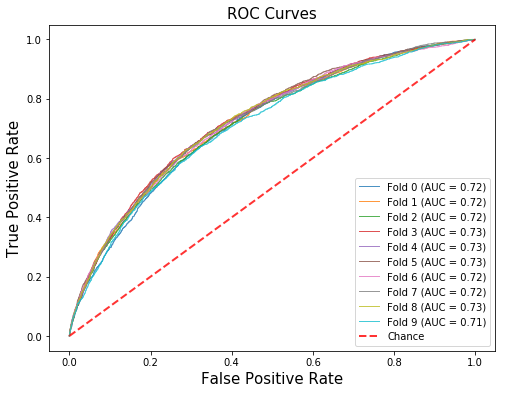

In [20]:
# Running the 'Best' hyperparameters back through the model with original under sampled data

clr = LogisticRegression(C=0.001, penalty='l1')

# Calling the cross validation function
metrics, chart, matrix = classify_folds(clr, np.array(train_set), np.array(train_labels), 'under', 10)

# Saving results
metrics.to_csv(path+'/results/LR_best_params.csv')

print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

With the 'tuned' hyperparamters, recall improves slightly to 73% with a small drop in precision. In summary, Recall ~ 73%, Precision ~ 14%, ROC AUC ~ 72%.

<a id='grid_rf'></a>
### b. Random Forest

[Return](#toc)

In [51]:
# WARNING - LONG RUN TIME...

from sklearn.model_selection import GridSearchCV

clr = RandomForestClassifier(n_jobs=-1, random_state=777)

# Exploring number of estimators, samples per leaf, number of features and tree depth
param_grid=[{'n_estimators':[3, 10, 100, 200, 500], 'min_samples_leaf':[1,10,20], 'max_features':[8, 16 ,32, 100], 'max_depth':[10, 50, 100, None]}]

grid_search = GridSearchCV(clr, param_grid, cv=5, scoring = ['roc_auc', 'precision', 'recall'], n_jobs=-1, refit='recall')
grid_search.fit(np.array(train_bal), np.array(train_bal_labels))

print('Best Parameters:')
print(grid_search.best_params_)

#pd.DataFrame(grid_search.best_params_, index=[1]).to_csv(path+'/results/RF_GridSearch_Best.csv')

Best Parameters:
{'max_depth': 10, 'max_features': 32, 'min_samples_leaf': 10, 'n_estimators': 500}


In [55]:
cvres = grid_search.cv_results_
cvres_frame = pd.DataFrame({'mean_test_recall':cvres["mean_test_recall"], 'mean_test_precision':cvres['mean_test_precision'], 'mean_test_roc_auc':cvres['mean_test_roc_auc'], "params":cvres['params']})

#cvres_frame.to_csv(path+'/results/RF_GridSearch.csv')

print('Results from Grid Search:')
cvres_frame.head()

Results from Grid Search:


,mean_test_recall,mean_test_precision,mean_test_roc_auc,params
0,0.634344,0.614568,0.659222,"{'max_depth': 10, 'max_features': 8, 'min_samp..."
1,0.655924,0.643856,0.697128,"{'max_depth': 10, 'max_features': 8, 'min_samp..."
2,0.672786,0.663745,0.725616,"{'max_depth': 10, 'max_features': 8, 'min_samp..."
3,0.674512,0.664053,0.727652,"{'max_depth': 10, 'max_features': 8, 'min_samp..."
4,0.674915,0.665688,0.729359,"{'max_depth': 10, 'max_features': 8, 'min_samp..."


0123456789
Confusion matrix from last fold:

Predicted      0     1
Actual                
0          13470  6311
1            579  1165

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.740336  0.668400   0.154370  0.250813  0.678900
1     0.746974  0.672284   0.156775  0.254258  0.684707
2     0.741800  0.668187   0.161144  0.259665  0.689538
3     0.757511  0.704159   0.160889  0.261931  0.685311
4     0.746742  0.687358   0.159910  0.259458  0.679922
5     0.750831  0.686205   0.159994  0.259487  0.692697
6     0.744032  0.687605   0.160261  0.259939  0.675695
7     0.744544  0.693775   0.162336  0.263108  0.678095
8     0.745513  0.685781   0.159217  0.258434  0.687526
9     0.731389  0.668005   0.155832  0.252711  0.679907
Mean  0.744967  0.682176   0.159073  0.257980  0.683230


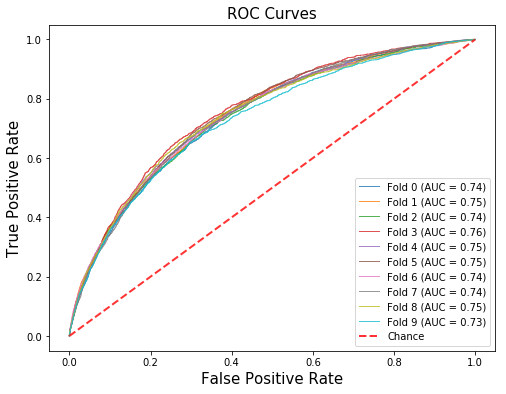

In [11]:
# Running the 'Best' hyperparameters back through the model with original under sampled data

clr = RandomForestClassifier(max_depth=10, max_features=32, min_samples_leaf=10, n_estimators=500, n_jobs=-1, random_state=777)

# Calling the cross validation function
metrics, chart, matrix = classify_folds(clr, np.array(train_set), np.array(train_labels), 'under', 10)

# Saving results
metrics.to_csv(path+'/results/RF_best_params.csv')

print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

The 'tuned' hyperparameters have brought the performance of the Random Forest model into line with the other two models. Recall ~ 68%, Precision ~ 16%, ROC AUC ~ 74%.

<a id='grid_ada'></a>
### c. AdaBoost

[Return](#toc)

In [61]:
# The grid search was actually run twice with different max_depth parameters: (1) max_depth=1 (2) max_depth=10.
# The 'Best' hyperparameters for both trials were the same: learning_rate=1 and n_estimators=300.

from sklearn.model_selection import GridSearchCV

clr = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), random_state=777)

# Exploring number of estimators and learning rate
param_grid=[{'n_estimators':[10,100,300], 'learning_rate':[0.1, 1, 10]}]

grid_search = GridSearchCV(clr, param_grid, cv=5, scoring = ['roc_auc', 'precision', 'recall'], n_jobs=-1, refit='recall')
grid_search.fit(np.array(train_bal), np.array(train_bal_labels))

print('Best Parameters:')
print(grid_search.best_params_)

#pd.DataFrame(grid_search.best_params_, index=[1]).to_csv(path+'/results/ADA_GridSearch_Best_10.csv')

Best Parameters:
{'learning_rate': 1, 'n_estimators': 300}


In [64]:
cvres = grid_search.cv_results_
cvres_frame = pd.DataFrame({'mean_test_recall':cvres["mean_test_recall"], 'mean_test_precision':cvres['mean_test_precision'], 'mean_test_roc_auc':cvres['mean_test_roc_auc'], "params":cvres['params']})

#cvres_frame.to_csv(path+'/results/ADA_GridSearch_10.csv')

print('Results from Grid Search:')
cvres_frame

Results from Grid Search:


,mean_test_recall,mean_test_precision,mean_test_roc_auc,params
0,0.607815,0.628543,0.636727,"{'learning_rate': 0.1, 'n_estimators': 10}"
1,0.628474,0.633326,0.666723,"{'learning_rate': 0.1, 'n_estimators': 100}"
2,0.639178,0.647927,0.696611,"{'learning_rate': 0.1, 'n_estimators': 300}"
3,0.602751,0.608399,0.618309,"{'learning_rate': 1, 'n_estimators': 10}"
4,0.613339,0.615369,0.657050,"{'learning_rate': 1, 'n_estimators': 100}"
5,0.643840,0.642942,0.697276,"{'learning_rate': 1, 'n_estimators': 300}"
6,0.350809,0.515898,0.437239,"{'learning_rate': 10, 'n_estimators': 10}"
7,0.350809,0.515898,0.437239,"{'learning_rate': 10, 'n_estimators': 100}"
8,0.350809,0.515898,0.437239,"{'learning_rate': 10, 'n_estimators': 300}"


0123456789
Confusion matrix from last fold:

Predicted      0     1
Actual                
0          13653  6128
1            585  1159

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.744750  0.688042   0.162572  0.263001  0.689910
1     0.757162  0.694364   0.163766  0.265026  0.692093
2     0.746221  0.656784   0.160984  0.258586  0.693115
3     0.762547  0.694200   0.166269  0.268282  0.699712
4     0.752650  0.679385   0.163469  0.263530  0.690235
5     0.751915  0.678508   0.160123  0.259100  0.695531
6     0.750328  0.677510   0.167522  0.268624  0.694416
7     0.747073  0.679192   0.164159  0.264410  0.686969
8     0.754553  0.683441   0.163015  0.263241  0.696260
9     0.736677  0.664564   0.159050  0.256671  0.688130
Mean  0.750388  0.679599   0.163093  0.263047  0.692637


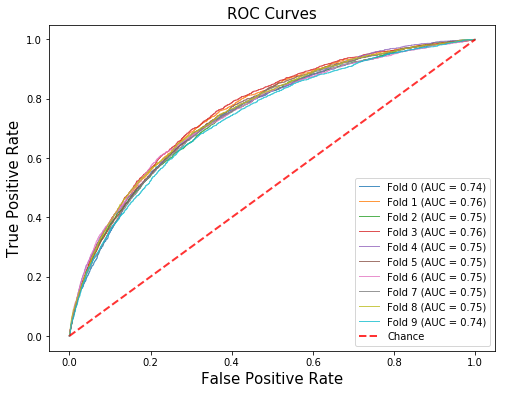

In [5]:
# Running the 'Best' hyperparameters back through the model with under sampled data
# Both max_depth=1 and max_depth=10 were tested

# max_depth = 10
#clr = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), learning_rate = 1, n_estimators=300, random_state=777)

# max_depth = 1
clr = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), learning_rate = 1, n_estimators=300, random_state=777)

# Calling the cross validation function
metrics, chart, matrix = classify_folds(clr, np.array(train_set), np.array(train_labels), 'under', 10)

# Saving results
metrics.to_csv(path+'/results/AdaBoost_best_params.csv')

print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

The results were better with max_depth=1, so the full set of 'tuned' hyperparamters becomes: max_depth=1, learning_rate=1 and n_estimators=300. Results were: recall ~68%, precision ~16% and ROC AUC ~75%.

<a id='tune_summary'></a>
# 7. Summary of Tuning Results
Below is a summary of the results from all three models using their respective 'tuned' hyperparameters, 10 fold cross validation and under sampling the majority class (TARGET = 0, no default).

[Return](#toc)

In [12]:
# Creating a summary dataframe from saved results
summary = pd.read_csv(path + '/results/LR_best_params.csv', index_col=0).loc[['Mean'],:]
summary = summary.append(pd.read_csv(path + '/results/RF_best_params.csv', index_col=0).loc[['Mean'],:])
summary = summary.append(pd.read_csv(path + '/results/AdaBoost_best_params.csv', index_col=0).loc[['Mean'],:])
summary.index=['Logistic Regression', 'Random Forest', 'AdaBoost']
#summary.to_csv(path+'/results/tuned_summary.csv', index=False)
print('Summary results with \'tuned\' hyperparamters and under sampling:\n')
summary

Summary results with 'tuned' hyperparamters and under sampling:



,ROC_AUC,Recall,Precision,F1-Score,Accuracy
Logistic Regression,0.721779,0.725579,0.135938,0.228970,0.605565
Random Forest,0.744967,0.682176,0.159073,0.257980,0.683230
AdaBoost,0.750388,0.679599,0.163093,0.263047,0.692637
